In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
file_paths = [
    f"../dataset/processed_data/df_{start:02d}_{end:02d}_cleaned.csv"
    for start, end in zip(range(0, 25, 5), range(4, 29, 5))
]

# 输出验证
print(file_paths)

# 读取数据并存入字典
dfs = {f"df_{i}": pd.read_csv(file,low_memory=False) for i, file in zip(["00_04", "05_09", "10_14", "15_19", "20_24"], file_paths)}

# 访问
#print(dfs["df_00_04"].head())  # 查看 2000-2004 年数据的前几行

['../dataset/processed_data/df_00_04_cleaned.csv', '../dataset/processed_data/df_05_09_cleaned.csv', '../dataset/processed_data/df_10_14_cleaned.csv', '../dataset/processed_data/df_15_19_cleaned.csv', '../dataset/processed_data/df_20_24_cleaned.csv']


In [3]:
print(dfs["df_00_04"].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14395 entries, 0 to 14394
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          14395 non-null  object 
 1   tourney_name        14395 non-null  object 
 2   draw_size           14395 non-null  int64  
 3   tourney_level       14395 non-null  int64  
 4   tourney_date        14395 non-null  object 
 5   match_num           14395 non-null  int64  
 6   winner_id           14395 non-null  int64  
 7   winner_seed         14395 non-null  float64
 8   winner_entry        14395 non-null  int64  
 9   winner_name         14395 non-null  object 
 10  winner_hand         14395 non-null  int64  
 11  winner_ht           14395 non-null  float64
 12  winner_ioc          14395 non-null  object 
 13  winner_age          14395 non-null  float64
 14  loser_id            14395 non-null  int64  
 15  loser_seed          14395 non-null  float64
 16  lose

### 技术指标分析

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# 选取比赛统计相关的特征
feature_cols = [
    'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 
    'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'winner_seed_bucket', 'loser_seed_bucket', 
    'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 
    'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'w_host', 'l_host'
]

# 初始化标准化工具
scaler = StandardScaler()
similarity_results = {}

for df_name, df in dfs.items():
    df_scaled = scaler.fit_transform(df[feature_cols])

    # 计算余弦相似度
    cosine_sim = cosine_similarity(df_scaled.T)

    # 计算欧几里得距离
    euclidean_dist = euclidean_distances(df_scaled.T)

    # 计算互信息（Mutual Information）
    mi_matrix = np.zeros((len(feature_cols), len(feature_cols)))
    for i, feat_x in enumerate(feature_cols):
        for j, feat_y in enumerate(feature_cols):
            if i != j:  # 互信息不计算自身
                mi_matrix[i, j] = mutual_info_regression(df[[feat_x]], df[feat_y]).mean()

    # 存入结果
    similarity_results[df_name] = {
        "cosine_similarity": pd.DataFrame(cosine_sim, index=feature_cols, columns=feature_cols),
        "euclidean_distance": pd.DataFrame(euclidean_dist, index=feature_cols, columns=feature_cols),
        "mutual_information": pd.DataFrame(mi_matrix, index=feature_cols, columns=feature_cols)
    }

# 查看某个年份的互信息矩阵
print(similarity_results)


{'df_00_04': {'cosine_similarity':                        w_ace      w_df    w_svpt   w_1stIn  w_1stWon  \
w_ace               1.000000  0.315200  0.380654  0.327137  0.461466   
w_df                0.315200  1.000000  0.512180  0.388918  0.419174   
w_svpt              0.380654  0.512180  1.000000  0.934544  0.907840   
w_1stIn             0.327137  0.388918  0.934544  1.000000  0.961183   
w_1stWon            0.461466  0.419174  0.907840  0.961183  1.000000   
w_2ndWon            0.359375  0.431306  0.781368  0.555451  0.552419   
w_SvGms             0.427004  0.471362  0.946019  0.893792  0.901367   
w_bpSaved           0.093518  0.340803  0.631225  0.577126  0.485927   
w_bpFaced           0.065305  0.394566  0.715598  0.650368  0.527141   
winner_seed_bucket  0.019907 -0.064310 -0.087418 -0.094281 -0.076245   
loser_seed_bucket   0.010573 -0.008858  0.019885  0.022276  0.015789   
l_ace               0.318967  0.214831  0.453868  0.441722  0.503234   
l_df                0.154845 

### 稀疏矩阵分析 host

In [5]:
# 遍历每个数据集
filtered_correlation_results = {}

for df_name, df in dfs.items():
    # 只保留 w_host 和 l_host 至少有一个为 1 的行
    filtered_df = df[(df['w_host'] != 0) | (df['l_host'] != 0)]
    
    filtered_df_scaled = scaler.fit_transform(filtered_df[feature_cols])
    # 计算余弦相似度
    cosine_sim = cosine_similarity(filtered_df_scaled_scaled.T)

    # 计算欧几里得距离
    euclidean_dist = euclidean_distances(filtered_df_scaled_scaled.T)

    # 计算互信息（Mutual Information）
    mi_matrix = np.zeros((len(feature_cols), len(feature_cols)))
    for i, feat_x in enumerate(feature_cols):
        for j, feat_y in enumerate(feature_cols):
            if i != j:  # 互信息不计算自身
                mi_matrix[i, j] = mutual_info_regression(df[[feat_x]], df[feat_y]).mean()

    # 存入结果
    similarity_results[df_name] = {
        "cosine_similarity": pd.DataFrame(cosine_sim, index=feature_cols, columns=feature_cols),
        "euclidean_distance": pd.DataFrame(euclidean_dist, index=feature_cols, columns=feature_cols),
        "mutual_information": pd.DataFrame(mi_matrix, index=feature_cols, columns=feature_cols)
    }

# 查看某个年份的互信息矩阵
print(similarity_results)

                     df_00_04  df_05_09  df_10_14  df_15_19  df_20_24
Pearson_Correlation -0.800699 -0.786872 -0.804535 -0.805243 -0.793836
Mutual_Information   0.407018  0.383376  0.405622  0.403590  0.414675


In [9]:
# 初始化标准化器和结果存储结构
scaler = StandardScaler()
similarity_results = {}

# 定义需要分析的host列
host_cols = ['w_host', 'l_host']

# 遍历每个数据集
for df_name, df in dfs.items():
    # 过滤数据：保留w_host或l_host至少有一个为1的行
    filtered_df = df[(df['w_host'] != 0) | (df['l_host'] != 0)].copy()
    
    # 标准化特征列（不包含host列）
    feature_data = scaler.fit_transform(filtered_df[feature_cols])
    
    # 提取host列数据（无需标准化）
    host_data = filtered_df[host_cols].values
    
    # ===== 计算指标 =====
    # 1. 余弦相似度（host列 vs 特征列）
    cosine_sim = cosine_similarity(host_data.T, feature_data.T)  # 形状: (2, len(feature_cols))
    
    # 2. 欧氏距离（host列 vs 特征列）
    euclidean_dist = euclidean_distances(host_data.T, feature_data.T)  # 形状: (2, len(feature_cols))
    
    # 3. 互信息（host列 vs 特征列）
    mi_matrix = np.zeros((len(host_cols), len(feature_cols)))
    for i, host_col in enumerate(host_cols):
        for j, feat_col in enumerate(feature_cols):
            # 注意：mutual_info_regression要求X为2D数组，y为1D
            mi_matrix[i, j] = mutual_info_regression(
                filtered_df[[feat_col]], 
                filtered_df[host_col]
            )[0]
    
    # ===== 结构化存储结果 =====
    similarity_results[df_name] = {
        "cosine_similarity": pd.DataFrame(
            cosine_sim,
            index=host_cols,
            columns=feature_cols
        ),
        "euclidean_distance": pd.DataFrame(
            euclidean_dist,
            index=host_cols,
            columns=feature_cols
        ),
        "mutual_information": pd.DataFrame(
            mi_matrix,
            index=host_cols,
            columns=feature_cols
        )
    }

# 示例：查看df_20_24中w_host与其他特征的互信息
print(similarity_results["df_20_24"]["mutual_information"])

        w_ace  w_df    w_svpt  w_1stIn  w_1stWon  w_2ndWon  w_SvGms  \
w_host    0.0   0.0  0.002015      0.0   0.00000  0.028075      0.0   
l_host    0.0   0.0  0.000000      0.0   0.00271  0.004029      0.0   

        w_bpSaved  w_bpFaced  winner_seed_bucket  loser_seed_bucket     l_ace  \
w_host   0.016926   0.026125             0.01065           0.002431  0.015676   
l_host   0.000000   0.009145             0.00000           0.022741  0.000000   

            l_df    l_svpt  l_1stIn  l_1stWon  l_2ndWon   l_SvGms  l_bpSaved  \
w_host  0.021407  0.004023      0.0  0.000000  0.001015  0.000000   0.022072   
l_host  0.000000  0.000000      0.0  0.011604  0.004235  0.009568   0.008964   

        l_bpFaced    w_host    l_host  
w_host   0.003035  0.697270  0.397240  
l_host   0.003355  0.395325  0.667222  


In [10]:
print(similarity_results)

{'df_00_04': {'cosine_similarity':            w_ace      w_df    w_svpt   w_1stIn  w_1stWon  w_2ndWon   w_SvGms  \
w_host  0.056075 -0.007471 -0.007854  0.004957  0.014494 -0.019142 -0.000927   
l_host -0.065195 -0.005933 -0.004617 -0.010149 -0.021471 -0.000012 -0.012079   

        w_bpSaved  w_bpFaced  winner_seed_bucket  loser_seed_bucket     l_ace  \
w_host   0.004787  -0.001735            0.029564           0.052706 -0.003476   
l_host  -0.003686   0.000544           -0.014262          -0.048531 -0.004472   

            l_df    l_svpt   l_1stIn  l_1stWon  l_2ndWon   l_SvGms  l_bpSaved  \
w_host -0.018081 -0.002620  0.011229  0.011043 -0.010715 -0.000295  -0.013181   
l_host  0.004352 -0.008204 -0.017084 -0.019585 -0.006931 -0.012099   0.005137   

        l_bpFaced    w_host    l_host  
w_host  -0.019593  0.665366 -0.532758  
l_host   0.014373 -0.535098  0.668288  , 'euclidean_distance':             w_ace       w_df     w_svpt    w_1stIn   w_1stWon   w_2ndWon  \
w_host  61.491212

### 计算场地相关性

In [14]:
from collections import defaultdict
import pandas as pd

# 初始化球员数据存储结构（包含不同场地类型） 删除carpet
player_stats = defaultdict(lambda: {
    'Clay': {'wins': 0, 'matches': 0},
    'Grass': {'wins': 0, 'matches': 0},
    'Hard': {'wins': 0, 'matches': 0},
    'total': {'wins': 0, 'matches': 0}  # 保留总统计数据
})

# 遍历每个年份的数据集 删除carpet
for df_name, df in dfs.items():
    for _, row in df.iterrows():
        # 确定当前比赛的场地类型
        surface = None
        if row['surface_Clay'] == 1:
            surface = 'Clay'
        elif row['surface_Grass'] == 1:
            surface = 'Grass'
        elif row['surface_Hard'] == 1:
            surface = 'Hard'
        else:
            continue  # 跳过无场地类型或无效数据
        
        winner_id = row["winner_id"]
        loser_id = row["loser_id"]
        winner_rank = row['winner_rank']
        loser_rank = row['loser_rank']
        
        # 更新总统计数据
        player_stats[winner_id]['total']['wins'] += 1
        player_stats[winner_id]['total']['matches'] += 1
        player_stats[loser_id]['total']['matches'] += 1

        player_stats[winner_id]['oponent_id'] = loser_id
        player_stats[winner_id]['rank'] = winner_rank
        player_stats[winner_id]['oponent_rank'] = loser_rank
        player_stats[loser_id]['oponent_id'] = winner_id
        player_stats[loser_id]['rank'] = loser_rank
        player_stats[loser_id]['oponent_rank'] = winner_rank
        
        # 更新场地特定数据
        if surface:  # 确保有有效场地类型
            player_stats[winner_id][surface]['wins'] += 1
            player_stats[winner_id][surface]['matches'] += 1
            player_stats[loser_id][surface]['matches'] += 1

# 转换为 DataFrame
rows = []
for player_id, stats in player_stats.items():
    row = {'player_id': player_id,
           'rank':stats['rank'],
           'oponent_id': stats['oponent_id'],
           'oponent_rank': stats['oponent_rank']}


    
    # 总统计数据
    total = stats['total']
    row['total_wins'] = total['wins']
    row['total_matches'] = total['matches']
    row['total_win_rate'] = total['wins'] / total['matches'] if total['matches'] > 0 else None
    
    # 各场地统计数据 删除carpet
    for surface in [ 'Clay', 'Grass', 'Hard']:
        surface_stats = stats[surface]
        row[f'{surface}_wins'] = surface_stats['wins']
        row[f'{surface}_matches'] = surface_stats['matches']
        row[f'{surface}_win_rate'] = (surface_stats['wins'] / surface_stats['matches'] 
                                      if surface_stats['matches'] > 0 else None)
    
    rows.append(row)

player_stats_df = pd.DataFrame(rows)


In [15]:
# 显示前几行查看结果
print(player_stats_df.describe())

           player_id         rank     oponent_id  oponent_rank   total_wins  \
count    1762.000000  1762.000000    1762.000000   1762.000000  1762.000000   
mean   122122.615210   414.813807  122549.721339    160.401082    38.630533   
std     36153.752336   361.632297   35555.028559    255.347161    97.940717   
min    100644.000000     1.000000  100644.000000      1.000000     0.000000   
25%    103498.250000   172.250000  103794.000000     40.000000     0.000000   
50%    104970.500000   287.500000  105051.000000     76.000000     2.000000   
75%    111787.750000   542.000000  123795.000000    139.750000    25.000000   
max    212970.000000  2159.000000  212203.000000   1890.000000  1182.000000   

       total_matches  total_win_rate    Clay_wins  Clay_matches  \
count    1762.000000     1762.000000  1762.000000   1762.000000   
mean       77.261067        0.268349    12.385358     24.770715   
std       162.214635        0.223762    33.901763     56.198790   
min         1.000000

In [16]:
player_stats_df.isna().sum()

player_id           0
rank                0
oponent_id          0
oponent_rank        0
total_wins          0
total_matches       0
total_win_rate      0
Clay_wins           0
Clay_matches        0
Clay_win_rate     549
Grass_wins          0
Grass_matches       0
Grass_win_rate    914
Hard_wins           0
Hard_matches        0
Hard_win_rate     313
dtype: int64

In [18]:
player_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1762 entries, 0 to 1761
Data columns (total 16 columns):
player_id         1762 non-null int64
rank              1762 non-null float64
oponent_id        1762 non-null int64
oponent_rank      1762 non-null float64
total_wins        1762 non-null int64
total_matches     1762 non-null int64
total_win_rate    1762 non-null float64
Clay_wins         1762 non-null int64
Clay_matches      1762 non-null int64
Clay_win_rate     1213 non-null float64
Grass_wins        1762 non-null int64
Grass_matches     1762 non-null int64
Grass_win_rate    848 non-null float64
Hard_wins         1762 non-null int64
Hard_matches      1762 non-null int64
Hard_win_rate     1449 non-null float64
dtypes: float64(6), int64(10)
memory usage: 220.4 KB


In [23]:
# 筛选总比赛场次小于5的选手
low_matches_df = player_stats_df[player_stats_df['total_matches'] < 2]

# 生成统计摘要
desc_stats = low_matches_df.describe(include='all')

# 显示关键统计指标（可根据需要调整）
print("低场次选手统计摘要（总比赛 < 2）：")
print(desc_stats.loc[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

低场次选手统计摘要（总比赛 < 2）：
           player_id         rank     oponent_id  oponent_rank  total_wins  \
count     356.000000   356.000000     356.000000    356.000000  356.000000   
mean   127163.092697   702.215377  116516.848315    203.958203    0.044944   
std     40356.864744   432.169241   29730.302212    316.304661    0.207472   
min    101167.000000   151.000000  101086.000000      2.000000    0.000000   
25%    103645.000000   341.500000  103290.250000     51.750000    0.000000   
50%    105226.500000   587.500000  104485.500000     89.000000    0.000000   
75%    126543.000000   988.750000  106256.250000    158.000000    0.000000   
max    212970.000000  2159.000000  212203.000000   1774.000000    1.000000   

       total_matches  total_win_rate   Clay_wins  Clay_matches  Clay_win_rate  \
count          356.0      356.000000  356.000000    356.000000     122.000000   
mean             1.0        0.044944    0.016854      0.342697       0.049180   
std              0.0        0.2074

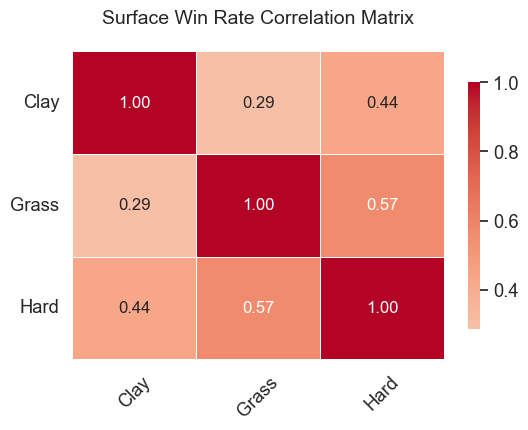

场地胜率皮尔逊相关系数矩阵：
                Clay_win_rate  Grass_win_rate  Hard_win_rate
Clay_win_rate        1.000000        0.288082       0.436430
Grass_win_rate       0.288082        1.000000       0.568777
Hard_win_rate        0.436430        0.568777       1.000000


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# 提取场地胜率数据（过滤无效数据）删除carpet
surface_win_rates = player_stats_df[
    ['Clay_win_rate', 'Grass_win_rate', 'Hard_win_rate']
].dropna()
 
# 计算皮尔逊相关系数矩阵 删除carpet
corr_matrix = surface_win_rates.corr(method='pearson')

# 设置可视化样式
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)

# 绘制热力图
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 12},
    cbar_kws={"shrink": 0.8}
)

# 设置坐标轴标签  删除carpet
heatmap.set_title('Surface Win Rate Correlation Matrix', pad=20, fontsize=14)
heatmap.set_xticklabels(['Clay', 'Grass', 'Hard'], rotation=45)
heatmap.set_yticklabels(['Clay', 'Grass', 'Hard'], rotation=0)

plt.show()

# 输出数值结果
print("场地胜率皮尔逊相关系数矩阵：")
print(corr_matrix)

### 年份数据集差异分析

In [20]:
# 假设 df 是你的比赛数据
players = []

# 需要添加到每个 player 的通用比赛信息列 删除carpet
common_cols = [
    'tourney_id', 'tourney_name', 'draw_size', 'tourney_level', 'tourney_date', 
    'match_num', 'tourney_ioc', 'tourney_year', 'w_host', 'l_host', 
     'surface_Clay', 'surface_Grass', 'surface_Hard', 'round_code'
]

# 赢家和输家的数据映射
winner_map = {
    'id': 'winner_id', 'seed_bucket': 'winner_seed_bucket', 'entry': 'winner_entry', 'name': 'winner_name',
    'hand': 'winner_hand', 'ht': 'winner_ht', 'ioc': 'winner_ioc', 'age': 'winner_age',
    'ace': 'w_ace', 'df': 'w_df', 'svpt': 'w_svpt', '1stIn': 'w_1stIn', '1stWon': 'w_1stWon',
    '2ndWon': 'w_2ndWon', 'SvGms': 'w_SvGms', 'bpSaved': 'w_bpSaved', 'bpFaced': 'w_bpFaced',
    'rank': 'winner_rank', 'rank_points': 'winner_rank_points'
}

loser_map = {
    'id': 'loser_id', 'seed_bucket': 'loser_seed_bucket', 'entry': 'loser_entry', 'name': 'loser_name',
    'hand': 'loser_hand', 'ht': 'loser_ht', 'ioc': 'loser_ioc', 'age': 'loser_age',
    'ace': 'l_ace', 'df': 'l_df', 'svpt': 'l_svpt', '1stIn': 'l_1stIn', '1stWon': 'l_1stWon',
    '2ndWon': 'l_2ndWon', 'SvGms': 'l_SvGms', 'bpSaved': 'l_bpSaved', 'bpFaced': 'l_bpFaced',
    'rank': 'loser_rank', 'rank_points': 'loser_rank_points'
}

for key, df in dfs.items():
    # 遍历比赛数据并转换为 player 数据结构
    for _, row in df.iterrows():
        # 处理胜者
        player_winner = {col: row[val] for col, val in winner_map.items()}
        player_winner.update({col: row[col] for col in common_cols})
        player_winner['result'] = 1  # 赢家标记为 1
        player_winner['dataset'] = key  # 赋予数据集标识
        players.append(player_winner)

        # 处理败者
        player_loser = {col: row[val] for col, val in loser_map.items()}
        player_loser.update({col: row[col] for col in common_cols})
        player_loser['result'] = 0  # 败者标记为 0
        player_loser['dataset'] = key  # 赋予数据集标识
        players.append(player_loser)

# 转换为 DataFrame
player_df = pd.DataFrame(players)


In [21]:
player_df.to_csv( r"F:\大四\tennis_predicton\processed_data\player.csv", index=False, encoding="utf-8-sig")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
# 选取需要归一化的列
stat_cols = ['entry', 'hand', 'ht', 'age', 'ace', 'df', 'svpt', '1stIn', '1stWon',  
             '2ndWon', 'SvGms', 'bpSaved', 'bpFaced', 'rank', 'rank_points']

subset1 = [ 'rank_points','rank','ht','age']
subset2 = ['ace', 'df', 'svpt', '1stIn', '1stWon',  
             '2ndWon', 'SvGms', 'bpSaved', 'bpFaced' , 'hand', 'entry' ]

# 归一化数据
#scaler = MinMaxScaler()
#player_df[stat_cols] = scaler.fit_transform(player_df[stat_cols])
# Z-Score 标准化数据
scaler = StandardScaler()  # 使用 StandardScaler 进行 Z-Score 标准化
player_df[stat_cols] = scaler.fit_transform(player_df[stat_cols])

# 按 dataset 分组计算均值
dataset_stats = player_df.groupby('dataset')[stat_cols].mean().reset_index()

# 获取数据集名称
datasets = dataset_stats['dataset'].unique()
dataset_stats

,dataset,entry,hand,ht,age,ace,df,svpt,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,rank,rank_points
0,df_00_04,0.016801,0.020146,-0.227696,-0.312658,-0.062915,0.152284,-0.022897,-0.105049,-0.113325,0.075553,-0.038320,0.029516,0.052054,-0.002217,-0.241380
1,df_05_09,0.017193,0.044988,-0.137798,-0.201222,-0.047978,-0.083520,-0.043389,-0.040479,-0.052212,-0.036204,-0.050498,-0.012828,-0.006158,-0.010398,-0.097481
2,df_10_14,0.012135,-0.002078,0.059941,0.125796,-0.010516,-0.068146,-0.029473,-0.017918,-0.019031,-0.031862,-0.028189,-0.023369,-0.025925,-0.067005,0.142405
3,df_15_19,-0.002142,-0.048521,0.169642,0.314568,0.097502,0.039781,0.056255,0.063764,0.085903,0.045079,0.073179,-0.003007,-0.016481,0.045654,0.085111
4,df_20_24,-0.049011,-0.017926,0.165736,0.105211,0.029657,-0.053031,0.044040,0.114593,0.114027,-0.062171,0.049707,0.008480,-0.007323,0.034553,0.142409


C:\Users\lizzy\AppData\Local\Temp\ipykernel_8228\665569540.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap(cmap_name, len(datasets))(np.linspace(0.1, 1, len(datasets)))


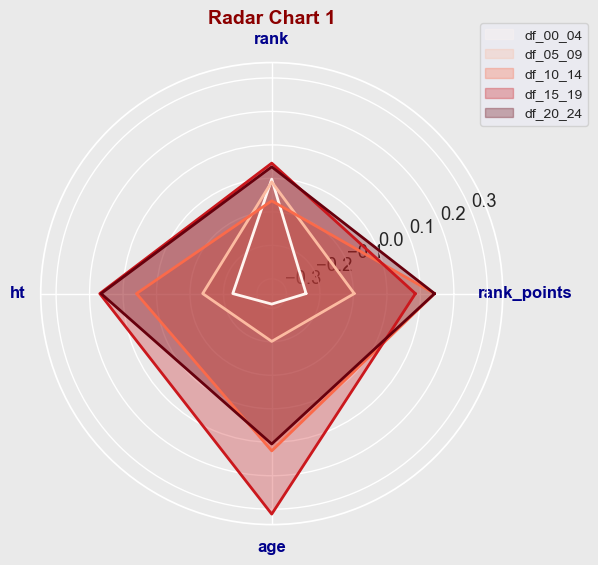

C:\Users\lizzy\AppData\Local\Temp\ipykernel_8228\665569540.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap(cmap_name, len(datasets))(np.linspace(0.1, 1, len(datasets)))


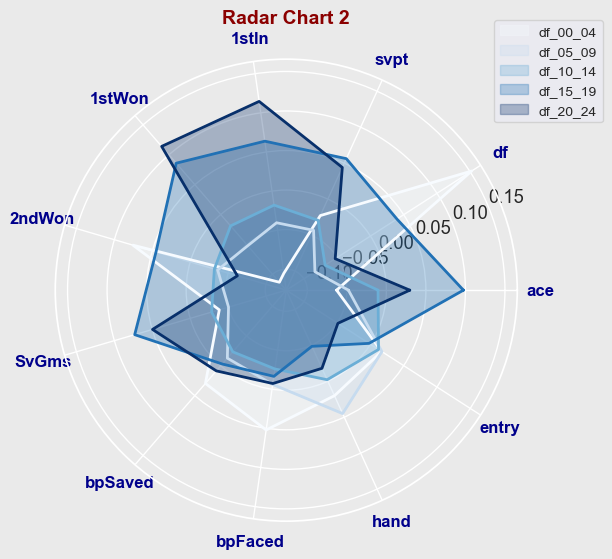

In [24]:
def plot_radar(df, categories, title, cmap_name='Blues'):
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
        # 设置雷达图背景颜色
    fig.patch.set_facecolor('#EAEAEA')  # 设置整个画布背景为浅灰色
    ax.set_facecolor('#EAEAEA')  # 设置雷达图背景为浅灰色


    # 生成颜色从浅到深的 colormap
    colors = cm.get_cmap(cmap_name, len(datasets))(np.linspace(0.1, 1, len(datasets)))

    for i, dataset in enumerate(datasets):
        values = df[df['dataset'] == dataset][categories].values.flatten()
        values = np.concatenate((values, [values[0]]))  # 闭合

        ax.fill(angles, values, color=colors[i], alpha=0.3, label=dataset)
        ax.plot(angles, values, color=colors[i], linewidth=2)



    # 设置角度标签
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold', rotation=45, color='darkblue')


    ax.set_title(title, fontsize=14, fontweight='bold', color='darkred')
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=10)
    
    plt.show()

# 绘制优化版雷达图
plot_radar(dataset_stats, subset1, "Radar Chart 1", cmap_name='Reds')
plot_radar(dataset_stats, subset2, "Radar Chart 2", cmap_name='Blues')

#### wassertein 距离、使用模型训练分类

In [25]:
from scipy.stats import wasserstein_distance

# 计算每两个年份数据的 Wasserstein 距离
wasserstein_results = {}

for i, year1 in enumerate(["00_04", "05_09", "10_14", "15_19", "20_24"]):
    for j, year2 in enumerate(["00_04", "05_09", "10_14", "15_19", "20_24"]):
        if i < j:
            dist = wasserstein_distance(dfs[f'df_{year1}']['winner_rank'], dfs[f'df_{year2}']['winner_rank'])
            wasserstein_results[f"{year1} vs {year2}"] = dist

# 查看结果
wasserstein_results


{'00_04 vs 05_09': 3.9893976194754606,
 '00_04 vs 10_14': 7.217223728043762,
 '00_04 vs 15_19': 7.75087751964581,
 '00_04 vs 20_24': 4.904062352876854,
 '05_09 vs 10_14': 4.1582004102881776,
 '05_09 vs 15_19': 6.819729161472569,
 '05_09 vs 20_24': 7.108346660368356,
 '10_14 vs 15_19': 10.900013861326132,
 '10_14 vs 20_24': 11.24910432447141,
 '15_19 vs 20_24': 3.9418784892203096}